In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [2]:
torch.__version__

'0.3.0.post4'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [4]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

In [5]:
X_train[X_train >= 0.5] = 1
X_train[X_train < 0.5] = 0

X_val[X_val >= 0.5] = 1
X_val[X_val < 0.5] = 0

X_test[X_test >= 0.5] = 1
X_test[X_test < 0.5] = 0

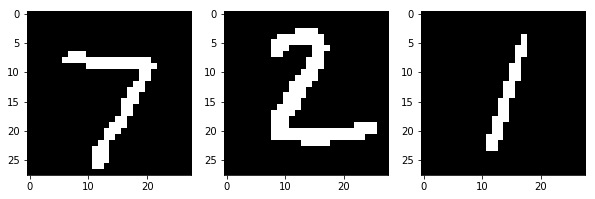

In [6]:
plt.figure(figsize=(10, 15))

num_examples = 3
for i in range(num_examples):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_test[i].reshape((28, 28)), cmap='gray')

In [7]:
cuda = torch.cuda.is_available()

In [8]:
cuda

True

In [9]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [11]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 28*28), latent_dim=2, n_samples=10):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.input_shape = input_shape
        
        self.encoder = nn.Sequential(
                            nn.Linear(input_shape[-1], 1024),
                            nn.ReLU(),
                            nn.Dropout(0.2),

                            nn.Linear(1024, 512),
                            nn.ReLU(),
                            nn.Dropout(0.1),
    
                            nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Dropout(0.1),

                            )
            
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        self.decoder = nn.Sequential(
                                nn.Linear(latent_dim, 256),
                                nn.ReLU(),
                                nn.Dropout(0.2),

                                nn.Linear(256, 512),
                                nn.ReLU(),
                                nn.Dropout(0.1),
            
                                nn.Linear(512, 1024),
                                nn.ReLU(),
                                nn.Dropout(0.1),
        
                                nn.Linear(1024, 2*input_shape[1]))

    def encode(self, x):
        enc_out = self.encoder(x)
        return self.fc_mu(enc_out), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        if self.training:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.n_samples, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)
            recon_x = probs[:,:,:,1]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)   
            recon_x = probs[:,:,1]
        return recon_x, log_probs
        
        
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x, log_probs = self.decode(z)
        return recon_x, log_probs, mu, logvar

In [12]:
def loss_function(log_probs, x, mu, logvar, n_samples=10):
    x = x.view(-1, 1, 28*28)
    x = x.repeat(1, n_samples, 1)

    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    
    if len(log_probs.shape)==4:
        LL = torch.sum((1-x)*log_probs[:,:,:,0] + x * log_probs[:,:,:,1]) / (x.shape[0]*n_samples)
    else:
        LL = torch.sum((1-x)*log_probs[:,:,0] + x * log_probs[:,:,1]) / (x.shape[0]*n_samples)

    elbo = LL - KLD
    loss = -1 * elbo
    return  loss, LL, KLD

In [13]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [14]:
log_interval = 10

def train_epoch(model, optimizer, X_adversarial=None, batchsize=32):
    loss_log = []
    ll_log = []
    kld_log = []
    
    if X_adversarial is not None:
        adv_loss_logs = [[] for i in range(len(X_adversarial))]
        adv_ll_logs = [[] for i in range(len(X_adversarial))]
        adv_kld_logs = [[] for i in range(len(X_adversarial))]
    
    
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        model.train()
        data = convert_to_var(x_batch.astype(np.float32))
        optimizer.zero_grad()
        recon_batch, log_probs, mu, logvar = model(data)
        loss, ll, kld = loss_function(log_probs, data, mu, logvar, model.n_samples)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.data[0])
        ll_log.append(ll.data[0])
        kld_log.append(kld.data[0])
        
        model.eval()
        if X_adversarial is not None:
            for i in range(len(X_adversarial)):
                data = convert_to_var(X_adversarial[[i]].astype(np.float32))
                recon_batch, log_probs, mu, logvar = model(data)
                loss, ll, kld = loss_function(log_probs, data, mu, logvar, model.n_samples)
                adv_loss_logs[i].append(loss.data[0])
                adv_ll_logs[i].append(ll.data[0])
                adv_kld_logs[i].append(kld.data[0])
            
    if X_adversarial is not None:
        return loss_log, ll_log, kld_log, \
               adv_loss_logs, adv_ll_logs, adv_kld_logs
    else:
        return loss_log, ll_log, kld_log

In [15]:
def train(model, optimizer, X_adversarial=None, num_epochs=5, batchsize=32):
    loss_log = []
    ll_log = []
    kld_log = []
    
    if X_adversarial is not None:
        adv_loss_logs = [[] for i in range(len(X_adversarial))]
        adv_ll_logs = [[] for i in range(len(X_adversarial))]
        adv_kld_logs = [[] for i in range(len(X_adversarial))]

    for i in range(num_epochs):
        epoch_results = train_epoch(model, optimizer, X_adversarial=X_adversarial, batchsize=32)    
        loss_log += epoch_results[0]
        ll_log += epoch_results[1]
        kld_log += epoch_results[2]
        
        if X_adversarial is not None:
            for i in range(len(X_adversarial)):
                adv_loss_logs[i] += epoch_results[3][i]
                adv_ll_logs[i] += epoch_results[4][i]
                adv_kld_logs[i] += epoch_results[5][i]
                
    if X_adversarial is not None:
        return loss_log, ll_log, kld_log, \
               adv_loss_logs, adv_ll_logs, adv_kld_logs
    else:
        return loss_log, ll_log, kld_log

In [16]:
def plot_learning_history(logs):
    
    loss_log, ll_log, kld_log = logs[:3]
    if len(logs) > 3:
        adv_loss_log, adv_ll_log, adv_kld_log = logs[3:]
    
    plt.figure(figsize=(20, 15))
    linewidth = 4
    
    plt.subplot(2, 3, 1)
    plt.plot(loss_log)
    plt.title('Loss')
    
    plt.subplot(2, 3, 2)
    plt.plot(ll_log)
    plt.title('LL')
    
    plt.subplot(2, 3, 3)
    plt.plot(kld_log)
    plt.title('KL')

    
    plt.subplot(2, 3, 4)
    for i in range(len(adv_loss_log)):
        plt.plot(adv_loss_log[i], label='Example {}'.format(i+1))
    plt.title('Adv Loss')
    plt.legend(loc='upper right')
    
    plt.subplot(2, 3, 5)
    for i in range(len(adv_ll_log)):
        plt.plot(adv_ll_log[i], label='Example {}'.format(i+1))
    plt.title('Adv LL')
    plt.legend(loc='upper right')
    
    plt.subplot(2, 3, 6)
    for i in range(len(adv_kld_log)):
        plt.plot(adv_kld_log[i], label='Example {}'.format(i+1))
    plt.title('Adv KLD')
    plt.legend(loc='upper right')


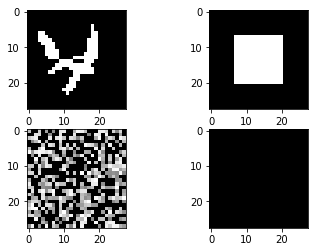

In [17]:
X_adversarial = np.zeros((4, 28*28))
mask = np.arange(28*28)

X_adversarial[0][mask < 28*14] = X_train[20][mask < 28*14]
X_adversarial[0][mask > 28*14] = X_train[9][mask > 28*14]

square_mask = np.array([[0 for _ in range(28)] for _ in range(7)] + \
                       [[1 if 7 <= i < 21 else 0 for i in range(28)] for _ in range(14)] + \
                       [[0 for _ in range(28)] for _ in range(7)]).flatten()
X_adversarial[1][square_mask == 1] = np.ones(14 * 14)

X_adversarial[2] = np.random.rand(28*28)
X_adversarial[2][X_adversarial[2] < 0.5] = 0
X_adversarial[2][X_adversarial[2] < 0.5] = 0


for i in range(X_adversarial.shape[0]):
    plt.subplot(2, X_adversarial.shape[0]//2, i+1)
    plt.imshow(X_adversarial[i].reshape((28,28)), cmap='gray')

In [38]:
%%time 
latent_dim=20
model = VAE(latent_dim=latent_dim, n_samples=10)
if cuda:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_logs = train(model, optimizer, X_adversarial=X_adversarial, num_epochs=10, batchsize=64)
clear_output()

CPU times: user 3min 44s, sys: 37.9 s, total: 4min 22s
Wall time: 4min 22s


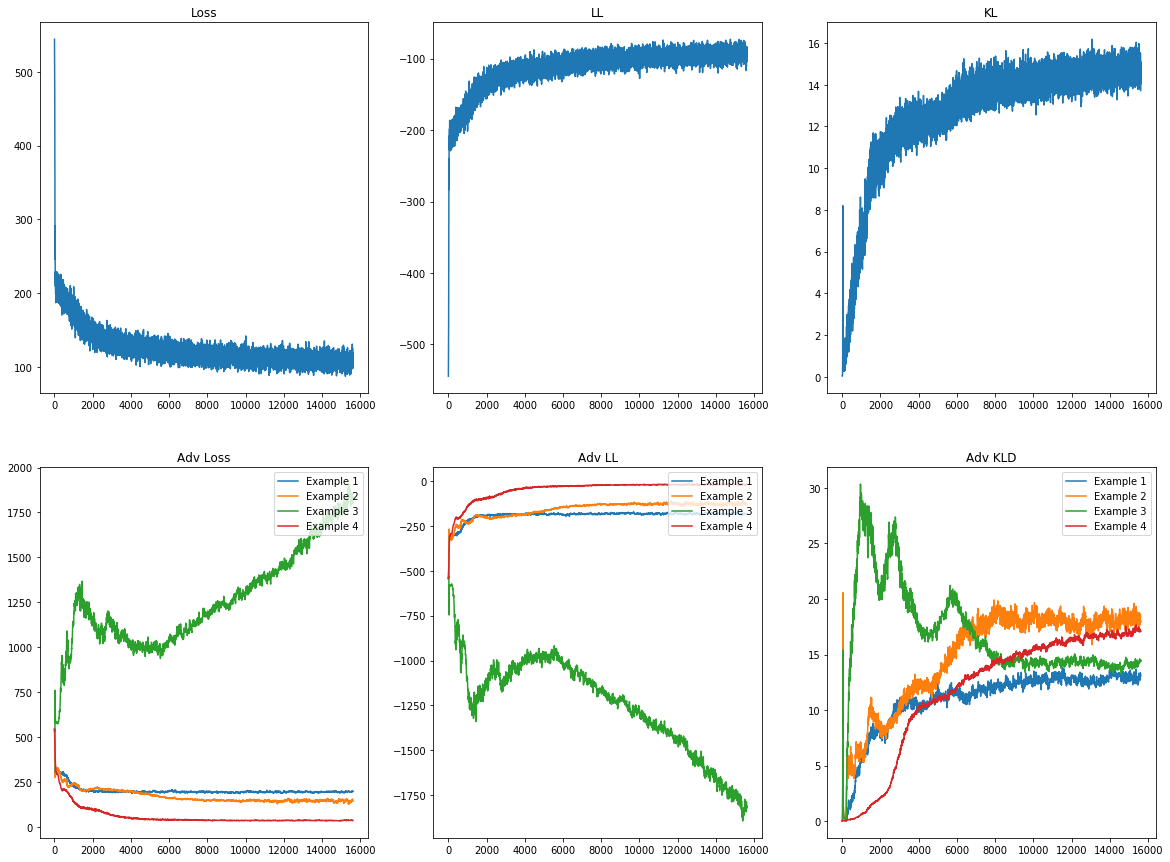

In [39]:
plot_learning_history(train_logs)

In [40]:
n=200
small_test_X = np.zeros((10*n, 784))
small_test_y = np.zeros((10*n))

for i in range(10):
    small_test_X[n*i:n*(i+1)] = X_test[y_test==i][:n]
    small_test_y[n*i:n*(i+1)] = y_test[y_test==i][:n]

recon_x, _, mu, logvar = model.forward(convert_to_var(small_test_X))
recon_x = recon_x.data.cpu().numpy()
mu = mu.data.cpu().numpy()
logvar = logvar.data.cpu().numpy()

In [41]:
colors = [np.random.rand(3) for _ in range(10)]

In [42]:
mu

array([[-0.03025008, -0.58851004,  1.47412527, ...,  0.05122686,
         0.03902756, -0.26216239],
       [ 0.01650166, -0.04247104,  0.17488158, ..., -0.02474701,
        -0.05641851, -1.90810692],
       [-0.02049826, -0.13424729, -0.50504285, ..., -0.0227687 ,
        -0.00334257, -0.23294935],
       ..., 
       [-0.01040047, -0.60111731, -1.19612229, ..., -0.00768397,
         0.00363724, -0.36428362],
       [-0.00722031, -0.34130663, -0.4272984 , ...,  0.00497324,
        -0.01207007, -1.01347005],
       [-0.02233921,  1.18204939, -1.42757905, ..., -0.0089649 ,
        -0.0172483 ,  0.67590177]], dtype=float32)

In [44]:
np.exp(0.5*logvar)

array([[ 0.98364103,  0.11968972,  0.14681341, ...,  0.99178958,
         0.98500776,  0.22678305],
       [ 0.99375981,  0.10576209,  0.09101512, ...,  1.00029171,
         0.99940383,  0.23430336],
       [ 0.98921859,  0.11272806,  0.07939613, ...,  0.9979704 ,
         0.99780822,  0.20008732],
       ..., 
       [ 0.99533087,  0.14558575,  0.11040765, ...,  0.99442905,
         0.99315757,  0.27600837],
       [ 0.99469495,  0.13689095,  0.08676244, ...,  0.98775649,
         0.99126321,  0.25945902],
       [ 0.99313408,  0.1241262 ,  0.08502093, ...,  1.00428796,
         1.00137305,  0.22482795]], dtype=float32)

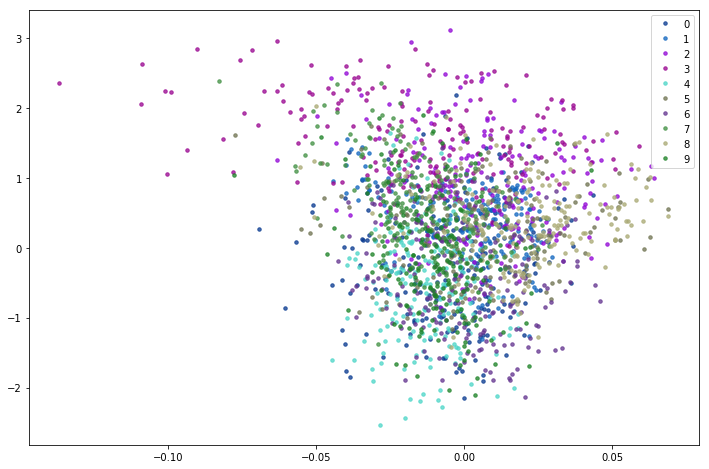

In [45]:
plt.figure(figsize=(12,8))
for i in range(len(small_test_X)):
    if i % 200==0:
        plt.plot(mu[i][0], mu[i][1], '.', markersize=7, alpha=0.75, color = colors[i//200]
                 ,label=str(int(small_test_y[i])))
    else:
        plt.plot(mu[i][0], mu[i][1], '.', markersize=7, alpha=0.75, color = colors[i//200])
        
plt.legend(loc='upper right')

### Reconstruction 

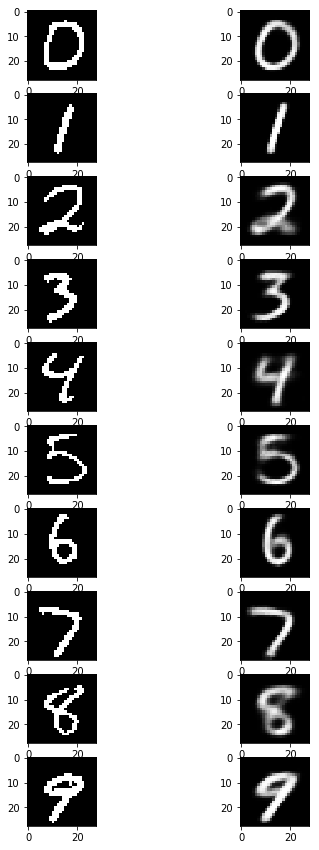

In [46]:
plt.figure(figsize=(7, 15))
n_plots = 10
for i in range(n_plots):
    plt.subplot(n_plots, 2, 2*i+1)
    plt.imshow(small_test_X[200*i+1].reshape((28,28)),cmap='gray')
    
    plt.subplot(n_plots, 2, 2*i+2)
    plt.imshow(recon_x[200*i+1].reshape((28,28)),cmap='gray')

## Random generating

In [47]:
model.eval()
random_predictions = model.decode(convert_to_var(np.random.randn(20*latent_dim).reshape((20,latent_dim))))[0]
random_predictions = random_predictions.data.cpu().numpy()

In [48]:
random_predictions.shape

(20, 784)

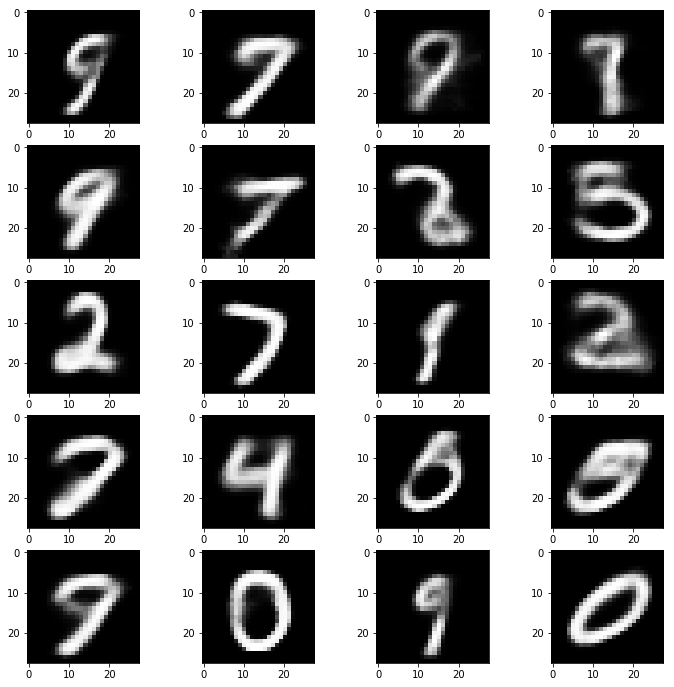

In [49]:
plt.figure(figsize=(12,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(random_predictions[i].reshape((28,28)), cmap='gray')